## Enhancing pytorch model inputs by adding additional datetime-based columns to TimeSeries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import shutil
from sklearn.preprocessing import MinMaxScaler
from tqdm.notebook import tqdm

from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

from u8timeseries import TimeSeries
from u8timeseries.preprocessing import ScalerWrapper
from u8timeseries.models import RNNModel, ExponentialSmoothing
from u8timeseries.metrics import mape
from u8timeseries.utils.statistics import check_seasonality, plot_acf


import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)
%load_ext autoreload
%autoreload 2
%matplotlib inline

Let's start out with a simple univariate sine time series.

In [2]:
def eval_model(model):
    pred_series = model.predict(n=20, use_full_output_length=True)
    plt.figure(figsize=(8,5))
    series_transformed.plot(label='actual')
    pred_series.plot(label='forecast')
    plt.title('MAPE: {:.2f}%'.format(mape(pred_series, val_transformed)))
    plt.legend();

In [3]:
# Read data:
df = pd.read_csv('AirPassengers.csv', delimiter=",")
series = TimeSeries.from_dataframe(df, 'Month', '#Passengers')

# Create training and validation sets:
train, val = series.split_after(pd.Timestamp('19590101'))

# Normalize the time series (note: we avoid fitting the transformer on the validation set)
transformer = ScalerWrapper()
train_transformed = transformer.fit_transform(train)
val_transformed = transformer.transform(val)
series_transformed = transformer.transform(series)

Let's try out a simple LSTM model on the AirPassenger data set without any additional inputs. After 100 epochs of training we get lacking results.

Training loss: 0.0188, validation loss: 0.0933


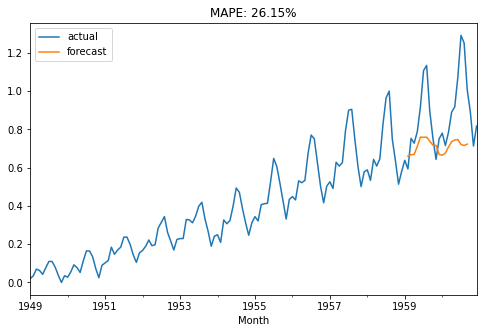

In [21]:
my_model = RNNModel(
    model='LSTM',
    output_length=10,
    hidden_size=10,
    n_rnn_layers=1,
    input_length=12,
    batch_size=16,
    n_epochs=300,
    optimizer_kwargs={'lr': 1e-3}, 
    dropout=0.3,
    model_name='Air_RNN', log_tensorboard=True,
)
my_model.fit(train_transformed, val_transformed, verbose=True)
eval_model(my_model)

We can see that adding additional one-hot encoded columns representing the month of every timestamp improved the accuracy of the forecast significantly.

Training loss: 0.0012, validation loss: 0.0304


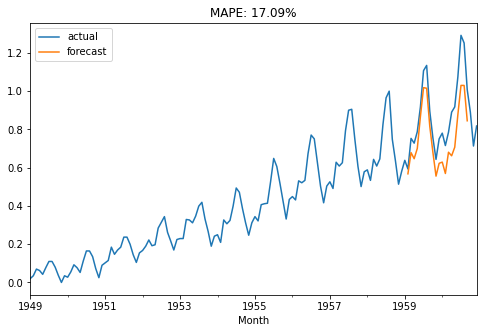

In [22]:
my_model = RNNModel(
    model='LSTM',
    output_length=10,
    hidden_size=25,
    n_rnn_layers=1,
    input_length=12,
    batch_size=16,
    n_epochs=300,
    optimizer_kwargs={'lr': 1e-3}, 
    dropout=0.3,
    model_name='Air_RNN', log_tensorboard=True,
    datetime_enhancements=['month']
)
my_model.fit(train_transformed, val_transformed, verbose=True)
eval_model(my_model)